### Mean-Variance Frontier with financial data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pandas_datareader.data as web

data = pd.DataFrame()
for code in ['005930', '000660', '035720', '035420'] : 
    data = pd.concat([data,web.DataReader(code, 'naver', start='2019-01-01', end='2020-01-01')['Close'].apply(int)], axis=1)

data.columns = ['se', 'skh', 'kk','nvr']
noa = len(data.columns)
data.head()

,se,skh,kk,nvr
2019-01-02 00:00:00,38750,60600,20473,118000
2019-01-03 00:00:00,37600,57700,20573,122000
2019-01-04 00:00:00,37450,58300,20774,125500
2019-01-07 00:00:00,38750,58700,20673,131500
2019-01-08 00:00:00,38100,59200,20051,130000


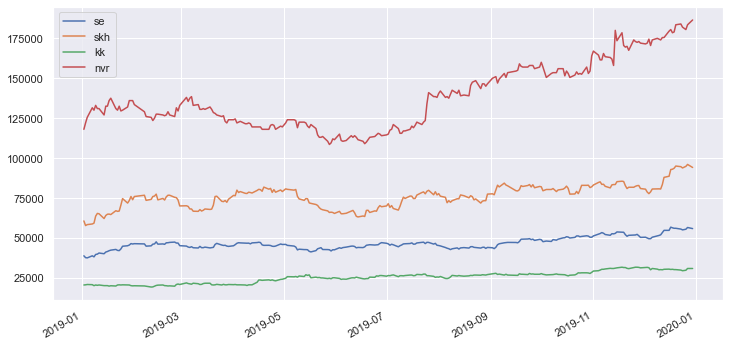

In [2]:
data.plot(figsize=(12,6))

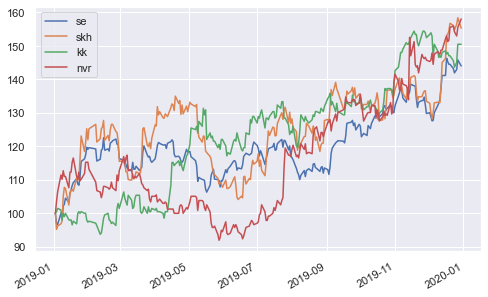

In [3]:
# Normalized Plot
(data / data.iloc[0] * 100).plot(figsize=(8, 5))

### Random Portfolio (random weights)

In [4]:
weights = np.random.random(noa)
weights /= sum(weights)

In [5]:
# get returns
ret = data.pct_change().dropna()

# use sample mean and variance as estimates of expected portfolio return and variance
port_mean = np.sum(weights * ret.mean() *250) # sample mean
port_var = np.dot(weights.T, np.dot(ret.cov()*250, weights)) #sample variance
port_std = np.sqrt(port_var) # sample standard deviation


### Now, we simulate $\left( \hat{\mu}, \hat{\sum} \right)$ with various weights

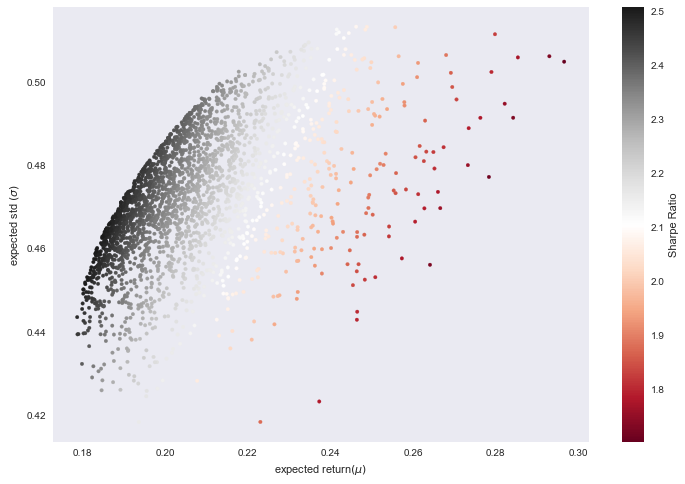

In [6]:
port_rets = []
port_std = []

def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() *250)
    port_var = np.dot(weight.T, np.dot(ret.cov()*250, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

for w in range(2500):
    weight = np.random.random(noa)
    weight /= np.sum(weight)
    mu, sig = ret_std(weight, ret)
#     print(mu, sig)
    port_rets.append(mu)
    port_std.append(sig)

sr = np.array(port_rets)/np.array(port_std)
    
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.scatter(port_std, port_rets, c=sr,marker='.',  cmap='RdGy')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('expected return$(μ)$')
plt.ylabel('expected std $(σ)$');
plt.grid()

In [7]:
def statistics(weights, rf=0):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(ret.mean() * weights) * 252 - rf
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

## Optimization 1: weights maximizing the Sharpe ratio
\begin{align*}
max_{w_i's} (sr)\equiv \frac{r_p-r_f}{\sigma_p} \\
~~& s.t   \sum w_i =1 , 0 \le w_i \le 1
\end{align*}

Let $r$

In [8]:
import scipy.optimize as opt

def min_func_sharpe(weights, rf=0):
    return -statistics(weights, rf)[2]

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
noa * [1. / noa,]

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

opts

     fun: -2.518584891871219
     jac: array([-1.16974115e-04, -3.48091125e-05,  1.03354454e-04,  5.45382500e-05])
 message: 'Optimization terminated successfully.'
    nfev: 39
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.35041199, 0.10066938, 0.2992044 , 0.24971424])

In [9]:
opts.x.round(3)

array([0.35 , 0.101, 0.299, 0.25 ])

In [10]:
statistics(opts['x']).round(3)

array([0.461, 0.183, 2.519])

## Optimization 2: weights minimizing variance (volatility)
\begin{align*}
min_{w_i's} \sigma_p^2 \\
~~& s.t   \sum w_i =1 , 0 \le w_i \le 1
\end{align*}

In [11]:
def min_func_volatility(weights):
    return statistics(weights)[1] **2

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
noa * [1. / noa,]

[0.25, 0.25, 0.25, 0.25]

In [12]:
optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [13]:
optv.x.round(3)

array([0.522, 0.   , 0.288, 0.19 ])

In [14]:
statistics(optv['x']).round(3)

array([0.442, 0.179, 2.473])

## Optimization 3: Optimal Portfolio Frontier
\begin{align*}
min_{w_i's} \sigma_p^2 \\
~~& s.t   \sum w_i =1 , 0 \le w_i \le 1,   r_p = \bar{r}
\end{align*}

In [15]:

def min_func_port(weights):
    return statistics(weights)[1]

cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

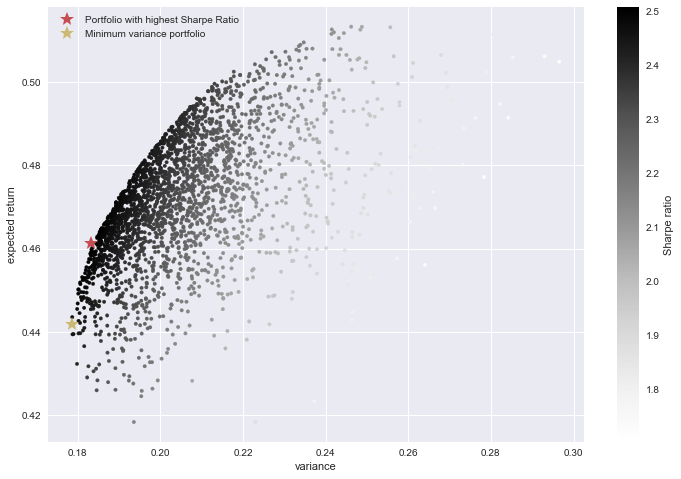

In [16]:
plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
            # random portfolio composition=
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=15.0, label = 'Minimum variance portfolio')
            # minimum variance portfolio  
plt.legend()
plt.grid(True)
plt.xlabel('variance')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

### Efficient Frontier with riskfree asset (CML, CAL)
- Let $r_f = 0.02$

In [17]:
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x*slope + rf for x in np.linspace(0.16,0.30,2500)]

NameError: name 'rf' is not defined

In [ ]:
x =  np.linspace(0.16,0.30,2500)
y = var_list

plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
plt.plot(x,y, label = 'mean-variance frontier with riskfree asset')
            # random portfolio composition  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
            # portfolio with highest Sharpe ratio
plt.ylim((0.4, 0.55))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')                    